# 01 Export Sentinel-1 composite to gcloud for selected AOI + last N days
Presentation [here](https://docs.google.com/presentation/d/1WFvmjGYE753JFsm_mDYHeU9QppFuJoauXEBVlIWVN8Q/edit#slide=id.g9f0a856913_0_14)

01.1 INSTALLING specific version

In [ ]:
%%capture
!pip install geemap
!pip install rasterio
!curl -s https://course.fast.ai/setup/colab | bash
!pip uninstall torch torchvision -y
!pip install torch==1.4.0 torchvision==0.5.0
!pip install geojson
!pip install geopandas

In [ ]:
import zipfile
import shapely.ops as ops
from shapely.geometry import shape, mapping
from shapely.geometry.multipolygon import MultiPolygon
from fastai.vision import *
import glob
import PIL
import zipfile
%reload_ext autoreload
%autoreload 2
%matplotlib inline
import numpy as np
import cv2
import subprocess
import matplotlib.pyplot as plt
from google.colab import auth
auth.authenticate_user()
#from google.cloud import bigquery
from google.cloud import storage
import os.path
import geojson
import datetime as dt
import os
from itertools import product
import rasterio as rio
from rasterio import windows
import pandas as pd
import geopandas as gpd
from rasterio import features
import rasterio.warp
import geojson
import json
import fiona
#import tensorflow as tf
#import tensorflow_hub as hub
import skimage.io as io
from IPython.display import clear_output
print(tf.__version__)

2.5.0


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import ee
ee.Authenticate()
ee.Initialize()
print(ee.__version__)

To authorize access needed by Earth Engine, open the following URL in a web browser and follow the instructions. If the web browser does not start automatically, please manually browse the URL below.

    https://accounts.google.com/o/oauth2/auth?client_id=517222506229-vsmmajv00ul0bs7p89v5m89qs8eb9359.apps.googleusercontent.com&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fearthengine+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdevstorage.full_control&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&response_type=code&code_challenge=dzNDuFlANOVvGgWKetSxpmQIkznqeYV4Zlgr0XwYu4o&code_challenge_method=S256

The authorization workflow will generate a code, which you should paste in the box below. 
Enter verification code: 4/1AY0e-g5mXfY4784dZP2Py4Yqh466jpStXZ_3ebq2Jgw-mimSpjJNQQGEcUI

Successfully saved authorization token.
0.1.266


In [ ]:
try:
    import google.colab
    import geemap.eefolium as emap
except:
    import geemap as emap

In [ ]:
#clear prev
#!ls -l
!rm -rf 'tmp'
!rm -rf 'tmp_tiles'
!rm -rf 'detected'
!rm -rf 'detected_tmp'
!rm -rf 'mosaic.tif'
shape_out_files = glob.glob('*detected*')
for shape_file in shape_out_files:
      os.remove(shape_file)

In [ ]:
!ls -l

total 12
-rw-r--r-- 1 root root  720 Jun  7 13:58 adc.json
drwx------ 6 root root 4096 Jun  7 13:59 drive
drwxr-xr-x 1 root root 4096 Jun  1 13:40 sample_data


01.2 LOAD MODEL FROM GDRIVE (1250*650) Pytorch FastAI

In [ ]:
# load model
def acc_camvid(input, target):
    target = target.squeeze(1)
    mask = target != void_code
    return (input.argmax(dim=1)[mask]==target[mask]).float().mean()
metrics = acc_camvid
path_learner = datapath4file("/content/drive/My Drive/Oil Spill Detection Dataset/train/images")
learn = load_learner(path_learner, 'restnet_101_weighted_loss_90ep_120unfreeze.pkl')

01.3 Set constant AOI, N-days, gcloud folders etc


In [ ]:
#add AOI (copy from GEE)
south_asia = ee.Geometry.Polygon([[[103.48507427743837, 4.824475978457538],
          [103.48507427743837, 3.3012594199438907],
          [106.86886333993837, 3.3012594199438907],
          [106.86886333993837, 4.824475978457538]]])

east_africa= ee.Geometry.Polygon([[[35.091607443647774, -15.909379057575116],
          [35.091607443647774, -23.675542129289955],
          [60.843560568647774, -23.675542129289955],
          [60.843560568647774, -15.909379057575116]]])
venesuela = ee.Geometry.Polygon(
        [[[-68.96670087712073, 12.625881021757197],
          [-68.96670087712073, 8.827010917781694],
          [-59.60634931462073, 8.827010917781694],
          [-59.60634931462073, 12.625881021757197]]])

brazil = ee.Geometry.Polygon(
        [[[-43.11162711844771, -7.213649884079331],
          [-43.11162711844771, -23.627857244287927],
          [-31.114556805947704, -23.627857244287927],
          [-31.114556805947704, -7.213649884079331]]])

west_africa=ee.Geometry.Polygon([[[6.393033150546423, 4.4374111277485895],
          [6.393033150546423, 2.7543909063653387],
          [10.002041939608922, 2.7543909063653387],
          [10.002041939608922, 4.4374111277485895]]])

north_sea=ee.Geometry.Polygon(
        [[[-2.2790611192269816, 59.136926077773616],
          [-2.2790611192269816, 53.39037667190538],
          [9.322501380773017, 53.39037667190538],
          [9.322501380773017, 59.136926077773616]]])
test = ee.Geometry.Polygon(
        [[[7.2919806670452925, 3.85485695482612],
          [7.2919806670452925, 3.4820878436466027],
          [7.7396735381390425, 3.4820878436466027],
          [7.7396735381390425, 3.85485695482612]]])

In [ ]:
#show aoi on Map
Map = emap.Map(center=(west_africa.centroid().coordinates().get(1).getInfo(), west_africa.centroid().coordinates().get(0).getInfo()), zoom=4)
Map.addLayer(south_asia, {'color':'red'}, 'south_asia', True)
Map.addLayer(east_africa, {'color':'red'}, 'east_africa', True)
Map.addLayer(venesuela, {'color':'red'}, 'venesuela', True)
Map.addLayer(brazil, {'color':'red'}, 'brazil', True)
Map.addLayer(west_africa, {'color':'red'}, 'west_africa', True)
Map.addLayer(north_sea, {'color':'red'}, 'north_sea', True)
Map.addLayer(test, {'color':'red'}, 'test', True)
Map

In [ ]:
ndays=10
today = dt.datetime.now()
day_before=today- dt.timedelta(days=ndays)
date_start=dt.datetime.strftime(day_before, "%Y-%m-%d")
date_end=dt.datetime.strftime(today, "%Y-%m-%d")
print(date_start,date_end)

2021-05-28 2021-06-07


In [ ]:
#for testing only
#date_start='2021-05-09'
#date_end='2021-05-19'

In [ ]:
ndays=10
#select aoi
aoi=west_africa
name='west_africa'
#Gcloud
cloud_id='peatfires-153915'
BUCKET = 'tf_classification_igg'
FOLDER = 'OILSPILLS/%s'% name
FOLDER_DET = 'OILSPILLS/%s/detected'%name
#export
BANDS=['VV']
# Specify the size and shape of patches expected by the model.
tile_width = 1025
tile_height = 650
kernel_buffer=8
KERNEL_SHAPE = [tile_width, tile_height]
image_base='img_src_%s_%s'%(name,date_start)
dims=[2560*2, 2560*2]

01.4 Create S1 composite and select only sea with Aster DEM

In [ ]:
def stretcher(bands,im,AOI,scale,range1,range2):
    stats = im.select(bands).clipToCollection(AOI).reduceRegion(
    reducer=ee.Reducer.percentile([range1,range2]),
    geometry=AOI,
    scale=scale,
    maxPixels= 1e15)
    imRGB = im.select(bands).visualize(
       min=ee.List([stats.get(bands[0]+'_p'+str(range1))]), 
       max=ee.List([stats.get(bands[0]+'_p'+str(range2))]), 
    )
    return im.set('im', imRGB)

def norm_to_float(image,aoi,scale):
  VV=image.select('VV')
  VVminMax = VV.reduceRegion(reducer=ee.Reducer.minMax(),geometry=aoi.getInfo(),scale=scale,maxPixels= 1e15)
  VV=VV.unitScale(ee.Number(VVminMax.get('VV_min')), ee.Number(VVminMax.get('VV_max')))
  return ee.Image([VV]).rename('VV')

In [ ]:
#S1 collection
s1 = ee.ImageCollection('COPERNICUS/S1_GRD').filterMetadata('transmitterReceiverPolarisation', 'equals', ['VV','VH']).filterBounds(aoi).filterDate(date_start,date_end)
#dem
dem = ee.Image("JAXA/ALOS/AW3D30/V2_2").select('AVE_DSM').unmask().clip(aoi)
#mask less then 1m height
dmask = ee.Image(dem.lt(1))
print(s1.size().getInfo())

6


In [ ]:
#stretching
source_im=s1.mean().updateMask(dmask)
stretched_im=stretcher(['VV'],source_im,ee.FeatureCollection(aoi),500,3,97)
#normalize to 0-1
stretched_im=ee.Image(stretched_im.get('im')).rename('VV')
#comp= norm_to_float(tmp,aoi,100).add(0.000001)

In [ ]:
#speckle filter func
#Functions to convert from/to dB
def toNatural(img):
  return ee.Image(10.0).pow(img.select(0).divide(10.0))

def toDB(img):
  return ee.Image(img).log10().multiply(10.0)

def toGamma0(img):
  return img.select(0).subtract(img.select(1).multiply(Math.PI/180.0).cos().log10().multiply(10.0))


#The RL speckle filter
def RefinedLee(img):
  #img must be in natural units, i.e. not in dB!
  #Set up 3x3 kernels 
  weights3 = ee.List.repeat(ee.List.repeat(1,3),3)
  kernel3 = ee.Kernel.fixed(3,3, weights3, 1, 1, False)

  mean3 = img.reduceNeighborhood(ee.Reducer.mean(), kernel3)
  variance3 = img.reduceNeighborhood(ee.Reducer.variance(), kernel3)

  #Use a sample of the 3x3 windows inside a 7x7 windows to determine gradients and directions
  sample_weights = ee.List([[0,0,0,0,0,0,0], [0,1,0,1,0,1,0],[0,0,0,0,0,0,0], [0,1,0,1,0,1,0], [0,0,0,0,0,0,0], [0,1,0,1,0,1,0],[0,0,0,0,0,0,0]])

  sample_kernel = ee.Kernel.fixed(7,7, sample_weights, 3,3, False)

  #Calculate mean and variance for the sampled windows and store as 9 bands
  sample_mean = mean3.neighborhoodToBands(sample_kernel)
  sample_var = variance3.neighborhoodToBands(sample_kernel)

  #Determine the 4 gradients for the sampled windows
  gradients = sample_mean.select(1).subtract(sample_mean.select(7)).abs()
  gradients = gradients.addBands(sample_mean.select(6).subtract(sample_mean.select(2)).abs())
  gradients = gradients.addBands(sample_mean.select(3).subtract(sample_mean.select(5)).abs())
  gradients = gradients.addBands(sample_mean.select(0).subtract(sample_mean.select(8)).abs())

  #And find the maximum gradient amongst gradient bands
  max_gradient = gradients.reduce(ee.Reducer.max())

  #Create a mask for band pixels that are the maximum gradient
  gradmask = gradients.eq(max_gradient)

  #duplicate gradmask bands: each gradient represents 2 directions
  gradmask = gradmask.addBands(gradmask)

  #Determine the 8 directions
  directions = sample_mean.select(1).subtract(sample_mean.select(4)).gt(sample_mean.select(4).subtract(sample_mean.select(7))).multiply(1)
  directions = directions.addBands(sample_mean.select(6).subtract(sample_mean.select(4)).gt(sample_mean.select(4).subtract(sample_mean.select(2))).multiply(2))
  directions = directions.addBands(sample_mean.select(3).subtract(sample_mean.select(4)).gt(sample_mean.select(4).subtract(sample_mean.select(5))).multiply(3))
  directions = directions.addBands(sample_mean.select(0).subtract(sample_mean.select(4)).gt(sample_mean.select(4).subtract(sample_mean.select(8))).multiply(4))
  #The next 4 are the not() of the previous 4
  directions = directions.addBands(directions.select(0).Not().multiply(5))
  directions = directions.addBands(directions.select(1).Not().multiply(6))
  directions = directions.addBands(directions.select(2).Not().multiply(7))
  directions = directions.addBands(directions.select(3).Not().multiply(8))

  #Mask all values that are not 1-8
  directions = directions.updateMask(gradmask)

  #"collapse" the stack into a singe band image (due to masking, each pixel has just one value (1-8) in it's directional band, and is otherwise masked)
  directions = directions.reduce(ee.Reducer.sum()) 

  #var pal = ['ffffff','ff0000','ffff00', '00ff00', '00ffff', '0000ff', 'ff00ff', '000000'];
  #Map.addLayer(directions.reduce(ee.Reducer.sum()), {min:1, max:8, palette: pal}, 'Directions', false);

  sample_stats = sample_var.divide(sample_mean.multiply(sample_mean))

  #Calculate localNoiseVariance
  sigmaV = sample_stats.toArray().arraySort().arraySlice(0,0,5).arrayReduce(ee.Reducer.mean(), [0])

  #Set up the 7*7 kernels for directional statistics
  rect_weights = ee.List.repeat(ee.List.repeat(0,7),3).cat(ee.List.repeat(ee.List.repeat(1,7),4))

  diag_weights = ee.List([[1,0,0,0,0,0,0], [1,1,0,0,0,0,0], [1,1,1,0,0,0,0], 
    [1,1,1,1,0,0,0], [1,1,1,1,1,0,0], [1,1,1,1,1,1,0], [1,1,1,1,1,1,1]])

  rect_kernel = ee.Kernel.fixed(7,7, rect_weights, 3, 3, False)
  diag_kernel = ee.Kernel.fixed(7,7, diag_weights, 3, 3, False)

  #Create stacks for mean and variance using the original kernels. Mask with relevant direction.
  dir_mean = img.reduceNeighborhood(ee.Reducer.mean(), rect_kernel).updateMask(directions.eq(1))
  dir_var = img.reduceNeighborhood(ee.Reducer.variance(), rect_kernel).updateMask(directions.eq(1))

  dir_mean = dir_mean.addBands(img.reduceNeighborhood(ee.Reducer.mean(), diag_kernel).updateMask(directions.eq(2)))
  dir_var = dir_var.addBands(img.reduceNeighborhood(ee.Reducer.variance(), diag_kernel).updateMask(directions.eq(2)))

  #and add the bands for rotated kernels
  for i in range(1,4):
    dir_mean = dir_mean.addBands(img.reduceNeighborhood(ee.Reducer.mean(), rect_kernel.rotate(i)).updateMask(directions.eq(2*i+1)))
    dir_var = dir_var.addBands(img.reduceNeighborhood(ee.Reducer.variance(), rect_kernel.rotate(i)).updateMask(directions.eq(2*i+1)))
    dir_mean = dir_mean.addBands(img.reduceNeighborhood(ee.Reducer.mean(), diag_kernel.rotate(i)).updateMask(directions.eq(2*i+2)))
    dir_var = dir_var.addBands(img.reduceNeighborhood(ee.Reducer.variance(), diag_kernel.rotate(i)).updateMask(directions.eq(2*i+2)))

  #"collapse" the stack into a single band image (due to masking, each pixel has just one value in it's directional band, and is otherwise masked)
  dir_mean = dir_mean.reduce(ee.Reducer.sum())
  dir_var = dir_var.reduce(ee.Reducer.sum())

  #A finally generate the filtered value
  varX = dir_var.subtract(dir_mean.multiply(dir_mean).multiply(sigmaV)).divide(sigmaV.add(1.0))

  b = varX.divide(dir_var)

  result = dir_mean.add(b.multiply(img.subtract(dir_mean)))
  return(result.arrayFlatten([['sum']]))




In [ ]:
#comp_vv = ee.Image(toDB(s1.map(toNatural).mean())).clip(aoi).rename('VV')
comp_vv1 = source_im
#comp_vv_lee= ee.Image(toDB(RefinedLee(toNatural(comp_vv)))).rename('VV')
comp_vv_lee1= ee.Image(toDB(RefinedLee(toNatural(comp_vv1)))).rename('VV')

01.5 Show on map

In [ ]:
Map = emap.Map(center=(aoi.centroid().coordinates().get(1).getInfo(), aoi.centroid().coordinates().get(0).getInfo()), zoom=8)
vizvv= {'bands': ['VV'],'min': -30, 'max': 17}
s1viz= {'min': 0, 'max': 255}
demviz= {'min': 0, 'max': 500,'palette': ['0000ff', '00ffff', 'ffff00', 'ff0000', 'ffffff']}
#Map.addLayer(source_im, vizvv, 'S1%s_source'%(date_start), True)
Map.addLayer(stretched_im, s1viz, 'S1%s_stretched'%(date_start), True)
Map.addLayer(comp_vv_lee1, vizvv, 'S1%s - speckle1'%(date_start), True)
#Map.addLayer(dem, demviz, 'DEM', True, 0.9)
Map

Chgeck best option for classifier (source, stretched or speckle filetered)

In [ ]:
crs=s1.first().select('VV').projection().crs().getInfo()
print(crs)

EPSG:32632


01.6 Export composite to gcloud as Geotif tiles

In [ ]:
#remove prev files
command='gsutil rm gs://'+BUCKET+'/'+FOLDER+'/*'
os.system(command)

0

In [ ]:
command='gsutil rm gs://'+BUCKET+'/'+FOLDER_DET+'/*'
os.system(command)

0

01.8 Export as TF records

In [ ]:
# def doExportTF(out_image_base, KERNEL_SHAPE,kernel_buffer, region):
#   """Run the image export task.  Block until complete.
#   """
#   task = ee.batch.Export.image.toCloudStorage(
#     image = comp_vv_lee1.select(BANDS), 
#     description = out_image_base, 
#     bucket = BUCKET, 
#     fileNamePrefix = FOLDER + '/' + out_image_base, 
#     region = aoi.getInfo()['coordinates'], 
#     scale = 10, 
#     fileFormat = 'TFRecord', 
#     maxPixels = 1e10,
#     formatOptions = { 
#       'patchDimensions': KERNEL_SHAPE,
#       'kernelSize': kernel_buffer,
#       'compressed': True,
#       'maxFileSize': 104857600
#     }
#   )
#   task.start()

#   # Block until the task completes.
#   print('Running image export to Cloud Storage...')
#   import time
#   while task.active():
#     time.sleep(30)

#   # Error condition
#   if task.status()['state'] != 'COMPLETED':
#     print('Error with image export.')
#   else:
#     print('Image export completed.')

In [ ]:
# #export task
# doExportTF(image_base, aoi,10,crs)

In [ ]:
def doExportIMG(out_image_base,region,scale,crs):
  """Run the image export task.  Block until complete.
  """
  task = ee.batch.Export.image.toCloudStorage(
    image = comp_vv_lee1.select(BANDS), 
    description = out_image_base, 
    bucket = BUCKET, 
    fileNamePrefix = FOLDER + '/' + out_image_base, 
    region = aoi,#.getInfo()['coordinates'], 
    scale=scale,
    crs=crs,
    #shardSize=25,
    fileDimensions=dims,  
    maxPixels = 1e13,
  )
  task.start()

  # Block until the task completes.
  print('Running image export to Cloud Storage...')
  import time
  while task.active():
    time.sleep(30)

  # Error condition
  if task.status()['state'] != 'COMPLETED':
    print('Error with image export.')
  else:
    print('Image export completed.')

In [ ]:
#export task
doExportIMG(image_base, aoi,10,crs)

Running image export to Cloud Storage...
Image export completed.


In [ ]:
tsks=ee.batch.Task.list()
print(tsks)

[<Task WJBU734FECPGV4SWTQK3S5UF EXPORT_IMAGE: img_src_west_africa_2021-05-28 (COMPLETED)>]


02 Get data from gcloud and create dataset for prediction


02.1 Get data from gcloud folder

In [ ]:
from google.cloud import storage
def get_files(BUCKET,FOLDER):
  storage_client = storage.Client(cloud_id)
  # Note: Client.list_blobs requires at least package version 1.17.0.
  blobs = storage_client.list_blobs(BUCKET,prefix=FOLDER)
  return blobs

In [ ]:
gsfiles=get_files(BUCKET,FOLDER)
flist=[]
for n,f in enumerate(gsfiles):
  flist.append(f.name)

In [ ]:
flist

['OILSPILLS/west_africa/img_src_west_africa_2021-05-280000000000-0000000000.tif',
 'OILSPILLS/west_africa/img_src_west_africa_2021-05-280000000000-0000005120.tif',
 'OILSPILLS/west_africa/img_src_west_africa_2021-05-280000000000-0000010240.tif',
 'OILSPILLS/west_africa/img_src_west_africa_2021-05-280000000000-0000015360.tif',
 'OILSPILLS/west_africa/img_src_west_africa_2021-05-280000000000-0000020480.tif',
 'OILSPILLS/west_africa/img_src_west_africa_2021-05-280000000000-0000025600.tif',
 'OILSPILLS/west_africa/img_src_west_africa_2021-05-280000000000-0000030720.tif',
 'OILSPILLS/west_africa/img_src_west_africa_2021-05-280000000000-0000035840.tif',
 'OILSPILLS/west_africa/img_src_west_africa_2021-05-280000005120-0000000000.tif',
 'OILSPILLS/west_africa/img_src_west_africa_2021-05-280000005120-0000005120.tif',
 'OILSPILLS/west_africa/img_src_west_africa_2021-05-280000005120-0000010240.tif',
 'OILSPILLS/west_africa/img_src_west_africa_2021-05-280000005120-0000015360.tif',
 'OILSPILLS/west

In [ ]:
len(flist)

32

In [ ]:
!rm -rf 'tmp'

In [ ]:
!rm -rf 'tmp_tiles'

In [ ]:
!mkdir 'tmp'

In [ ]:
!mkdir 'tmp_tiles'

In [ ]:
#!ls -l tmp

In [ ]:
def copy_files_from_gs(flist):
  #in_path = 'gs://'+BUCKET+'/'+FOLDER +'/'
  for n,f in enumerate(flist):
    input_filename = f
    out='tmp/img%s.tif'%(n)
    print(out)
    !gsutil cp gs://{BUCKET}/{input_filename} {out}

In [ ]:
%%capture
#!gsutil cp gs://{BUCKET}/{FOLDER}/{input_filename} /tmp/img.tif
copy_files_from_gs(flist)

In [ ]:
imgs = glob.glob( "tmp/*.tif")
print(len(imgs))

32


02.2 create single mosaic back 

In [ ]:
from rasterio.merge import merge
src_files_to_mosaic = []
for f in imgs:
  src = rio.open(f)
  src_files_to_mosaic.append(src)

In [ ]:
mosaic, out_trans = merge(src_files_to_mosaic)

In [ ]:
out_meta = src.meta.copy()
out_name='mosaic.tif'
out_meta.update({"driver": "GTiff",
                 "height": mosaic.shape[1],
                 "width": mosaic.shape[2],
                 "transform": out_trans,
                 "crs": crs
                 }
                )

In [ ]:
with rio.open(out_name, "w", **out_meta) as dest:
  dest.write(mosaic)

In [ ]:
!ls

In [ ]:
!rm -rf 'tmp'

In [ ]:
!mkdir 'tmp_tiles'

In [ ]:
#clear cashed list
src_files_to_mosaic=[]

In [ ]:
out_path = 'tmp_tiles/'
output_filename = '{}_{}-{}.tif'
img='mosaic.tif'

def get_tiles(ds, width=tile_width, height=tile_height):
    nols, nrows = ds.meta['width'], ds.meta['height']
    offsets = product(range(0, nols, width), range(0, nrows, height))
    big_window = windows.Window(col_off=0, row_off=0, width=nols, height=nrows)
    for col_off, row_off in  offsets:
        window =windows.Window(col_off=col_off, row_off=row_off, width=width, height=height).intersection(big_window)
        transform = windows.transform(window, ds.transform)
        yield window, transform


try:
    with rio.open(img) as inds:
      meta = inds.meta.copy()
      for window, transform in get_tiles(inds):
        #print(window)
        meta['transform'] = transform
        meta['width'], meta['height'] = window.width, window.height
        outpath = os.path.join(out_path,output_filename.format(img.split('.')[0],int(window.col_off), int(window.row_off)))
        with rio.open(outpath, 'w', **meta) as outds:
            outds.write(inds.read(window=window))
            #os.remove(outpath)
except IOError as e:
    print(e)

In [ ]:
tiles = glob.glob(out_path + "*")
len(tiles)

02.3 Check one tile

In [ ]:
tiles[0:10]

['tmp_tiles/mosaic_21525-650.tif',
 'tmp_tiles/mosaic_35875-11700.tif',
 'tmp_tiles/mosaic_23575-8450.tif',
 'tmp_tiles/mosaic_23575-4550.tif',
 'tmp_tiles/mosaic_23575-9100.tif',
 'tmp_tiles/mosaic_10250-7150.tif',
 'tmp_tiles/mosaic_13325-7150.tif',
 'tmp_tiles/mosaic_13325-3900.tif',
 'tmp_tiles/mosaic_28700-650.tif',
 'tmp_tiles/mosaic_0-14950.tif']

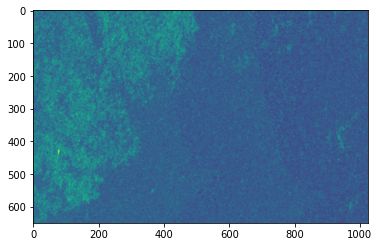

In [ ]:
#check one tile
tile = rio.open('tmp_tiles/mosaic_1025-1950.tif')
raw_input = tile.read(1)
masked_input = np.ma.masked_invalid(raw_input)
img = masked_input + ( masked_input.min()*-1)
img = img/img.max()
where_are_NaNs = np.isnan(img.data)
img.data[where_are_NaNs] = 0
plt.imshow(img)
plt.show()

In [ ]:
raw_input.dtype

dtype('float64')

In [ ]:
 img_fa=Image(pil2tensor(img, dtype=np.float32))
 img_fa.shape

torch.Size([1, 650, 1025])

In [ ]:
predicted_full = learn.predict(img_fa)
y = predicted_full[0]

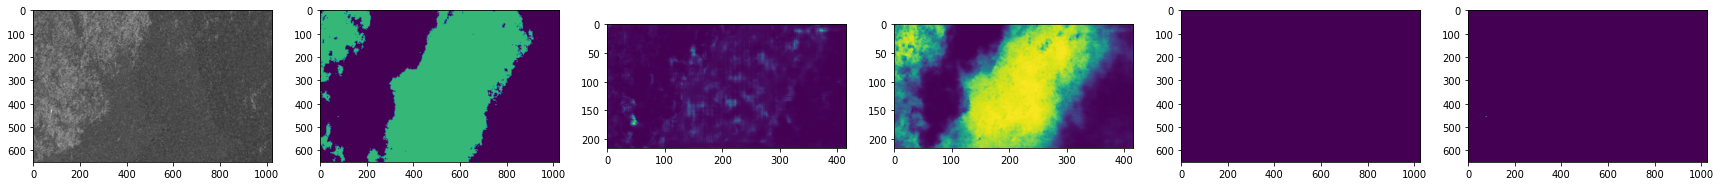

In [ ]:
#select 
pred=y.data.numpy()[0,:,:]
im_full = PIL.Image.fromarray(pred.astype(np.float32))
#resize
resized = im_full.resize(size=(raw_input.shape[1],raw_input.shape[0]) ,resample=cv2.INTER_LANCZOS4)
# select only oil class with prob >.95
probs_oil = predicted_full[2][1].numpy()
probs_loil = predicted_full[2][2].numpy()
#for source images
#out_oil = np.where((probs_oil > 0.7)|(probs_loil > 0.5),2,0).astype(np.float32)
#for stretched images and for spekled
out_oil = np.where((probs_oil > 0.75),1,0).astype(np.float32)
im_oil = PIL.Image.fromarray(out_oil.astype(np.float32))
resized_oil = im_oil.resize(size=(raw_input.shape[1],raw_input.shape[0]) ,resample=cv2.INTER_LANCZOS4)
out_oil = np.array(resized_oil).astype(np.uint8)
# select only ship class
out_ship = np.where(np.array(resized)==3,3,0).astype(np.uint8)
fig, (ax1, ax2,ax3,ax4,ax5,ax6) = plt.subplots(1,6, figsize=(30,30))
ax1.imshow(img, cmap="gray")
ax2.imshow(np.array(resized))
ax3.imshow(probs_oil)
ax4.imshow(probs_loil)
ax5.imshow(out_oil)
ax6.imshow(out_ship)

In [ ]:
np.unique(np.array(resized))

array([0., 2., 3.], dtype=float32)

0 Sea_Surface
1 Oil_Spill
2 Look_alike
3 Ship
4 Land

TMP: check transform and polygon extracting for one example

In [ ]:
# not used
def get_scale_trsf(rast):
  scale=round(rast.meta['transform'][0]*4,1)
  scale1=round(rast.meta['transform'][0]*-4,1)
  l1=rast.meta['transform'][2]
  l2=rast.meta['transform'][5]
  trnsf=[scale,0.0,l1,0.0,scale1,l2]
  return trnsf

03 Get prediction

In [ ]:
!rm -rf detected
!rm -rf detected_tmp
!mkdir detected
!mkdir detected_tmp

In [ ]:
from tqdm import tqdm_notebook as tqdm

In [ ]:
tiles = glob.glob(out_path + "*")
for t in tqdm(tiles):
  #print(tile)
  tile_name = t
  tile = rio.open(tile_name)
  raw_input = tile.read(1)
  #print(raw_input.dtype)
  masked_input = np.ma.masked_invalid(raw_input)
  img = masked_input + ( masked_input.min()*-1)
  # and ((np.count_nonzero(raw_input==0) /(raw_input.shape[0]*raw_input.shape[1]))<0.99)
  if (img.max()>0) and (raw_input.shape[1]==1025) and (raw_input.shape[0]==650):
    img = img/img.max()
    where_are_NaNs = np.isnan(img.data)
    img.data[where_are_NaNs] = 0
    img_fastai = Image(pil2tensor(img, dtype=np.float32))
    #print(tile_name+'----- start predict')
    predicted_full = learn.predict(img_fastai)
    res_img = predicted_full[0]
    res_img_numpy = res_img.data.numpy()[0,:,:]
    #print(res_img_numpy.shape)
    #get full predicted result
    im = PIL.Image.fromarray(res_img_numpy.astype(np.uint8))
    resized = im.resize(size=(raw_input.shape[1],raw_input.shape[0]) ,resample=cv2.INTER_LANCZOS4)
    out_full=np.array(resized).astype(np.uint8)
    print(np.unique(out_full))
    # apply threshold and set oil classes to background where less than 80%
    # extract probabilities for oil class
    probs_oil = predicted_full[2][1].numpy()
    probs_likeoil = predicted_full[2][2].numpy()
    #for source images
    #out_oil = np.where((probs_oil > 0.7)|(probs_loil > 0.5),2,0).astype(np.float32)
    #for stretched images
    sel_oil = np.where((probs_oil > 0.85),1,0).astype(np.float32)
    # now resize prediction image - this leads to shifted image, reason unknown!!:
    im = PIL.Image.fromarray(sel_oil.astype(np.uint8))
    resized_oil = im.resize(size=(raw_input.shape[1],raw_input.shape[0]) ,resample=cv2.INTER_LANCZOS4)
    #out_oil = np.where(np.array(resized)==1,2,0).astype(np.uint8)
    out_oil = np.array(resized_oil).astype(np.uint8)
    #select ships only from full result
    out_ship = np.where(np.array(resized)==3,3,0).astype(np.uint8)
    # Plot
    #if np.count_nonzero(out_array == 1)>80:
      #fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,20))
      #ax1.imshow(img, cmap="gray")
      #ax2.imshow(out_array)
      #plt.title(tile_name)
    if np.count_nonzero(out_full >= 1)>10:
      #plt.title("---DETECTED---"  + tile_name)
      #plt.savefig("detected_png" +tile_name[9:-4] + ".png", bbox_inches='tight')
      #if detection then write file
      rasterin = tile_name
      rasterout_full = "detected" + tile_name[9:-4] + "_full.tif"
      rasterout_oil = "detected_tmp" + tile_name[9:-4] + "_oil.tif"
      rasterout_ship = "detected_tmp" + tile_name[9:-4] + "_ship.tif"
      rast = rio.open(rasterin)
      meta = rast.meta
      meta.update(
        dtype=np.uint8,
        compress='lzw')
      rast.close()
      with rio.open(rasterout_full, 'w', **meta) as dst:
        dst.write(out_full, 1)
      dst.close()
      with rio.open(rasterout_oil, 'w', **meta) as dst:
        dst.write(out_oil, 1)
      dst.close()
      if np.count_nonzero(out_ship == 3)>1:
        with rio.open(rasterout_ship, 'w', **meta) as dst:
          dst.write(out_ship, 1)
        dst.close()
        print(tile_name + "  - ships detected")
      else:
        print(tile_name + " DETECTED - no ships detected")
      #os.system("mv " +  tile_name +  " detected_png" + tile_name[9:])
      print(tile_name + " DETECTED" )
      tile.close()
    else:
      print('%s has less than 1 detected pixels'%tile_name)
      tile.close()
  else:
    print(tile_name + " ----------------------has only nan" )
    tile.close()

In [ ]:
res_tiles = glob.glob('detected/*_full.tif')
print(res_tiles)

['detected/mosaic_8200-14950_full.tif', 'detected/mosaic_22550-14300_full.tif', 'detected/mosaic_3075-9100_full.tif', 'detected/mosaic_8200-11050_full.tif', 'detected/mosaic_17425-11050_full.tif', 'detected/mosaic_26650-3250_full.tif', 'detected/mosaic_23575-14950_full.tif', 'detected/mosaic_24600-11700_full.tif', 'detected/mosaic_20500-5850_full.tif', 'detected/mosaic_3075-10400_full.tif', 'detected/mosaic_15375-1950_full.tif', 'detected/mosaic_24600-5850_full.tif', 'detected/mosaic_5125-14300_full.tif', 'detected/mosaic_13325-2600_full.tif', 'detected/mosaic_9225-10400_full.tif', 'detected/mosaic_32800-3900_full.tif', 'detected/mosaic_5125-9750_full.tif', 'detected/mosaic_5125-6500_full.tif', 'detected/mosaic_17425-1950_full.tif', 'detected/mosaic_12300-1950_full.tif', 'detected/mosaic_5125-13650_full.tif', 'detected/mosaic_2050-13650_full.tif', 'detected/mosaic_1025-5200_full.tif', 'detected/mosaic_11275-7800_full.tif', 'detected/mosaic_20500-5200_full.tif', 'detected/mosaic_19475-1

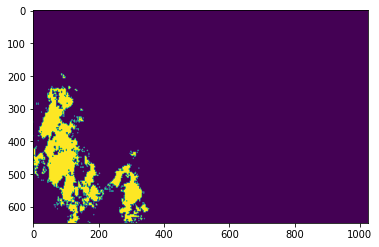

In [ ]:
tile = rio.open('detected/mosaic_1025-2600_full.tif')
raw_input = tile.read(1)
masked_input = np.ma.masked_invalid(raw_input)
img = masked_input + ( masked_input.min()*-1)
img = img/img.max()
where_are_NaNs = np.isnan(img.data)
img.data[where_are_NaNs] = 0
plt.imshow(img)
plt.show()

03.1 Create image footprint for detected tiles and store as GeoJson

In [ ]:
def create_geoms(tiles,name,date_start,date_end):
  name='detected_%s_%s.geojson'%(name,date_start)
  out = {'name': name,'type':'FeatureCollection', 'crs': {'type': 'name', 'properties': {'name': 'EPSG:4326'}},'features':[]}
  for tile in res_tiles:
    with rio.open(tile) as dataset:

      # Read the dataset's valid data mask as a ndarray.
      mask = dataset.dataset_mask()

      # Extract feature shapes and values from the array.
      for geom, val in rio.features.shapes(
            mask, transform=dataset.transform):

        # Transform shapes from the dataset's own coordinate
        # reference system to CRS84 (EPSG:4326).
        geom = rio.warp.transform_geom(
            dataset.crs, 'EPSG:4326', geom, precision=6)

        # Print GeoJSON shapes to stdout.
        #print(geom)
        feature = { 'type':'Feature','properties':{},"geometry":{}}
        feature['properties']['name'] = name
        feature['properties']['gloud_id'] = 'gs://'+BUCKET+'/'+FOLDER +'/'+tile
        feature['properties']['start_date'] = date_start
        feature['properties']['start_date'] = date_end
        feature['geometry']=geom
    out['features'].append(feature)
  return out

In [ ]:
geoms=create_geoms(res_tiles,name,date_start,date_end)

In [ ]:
with open('/content/drive/My Drive/OIL1/detected_%s_%s.geojson'%(name,date_start), 'w') as f:
   geojson.dump(geoms, f)

In [ ]:
with open('detected_%s_%s.geojson'%(name,date_start), 'w') as f:
   geojson.dump(geoms, f)

In [ ]:
#convert to shape into detected folder
res=gpd.read_file('detected_%s_%s.geojson'%(name,date_start))
#res.to_file('/content/drive/My Drive/OIL1/detected_%s_%s.shp'%(name,date_start))
res.to_file('detected/detected_%s_%s.shp'%(name,date_start))

In [ ]:
#!ls -l detected

03.2 Copy all result to gcloud

In [ ]:
command='gsutil rm gs://'+BUCKET+'/'+FOLDER_DET+'/*'
os.system(command)

256

In [ ]:
%%capture
!gsutil cp -r detected gs://{BUCKET}/{FOLDER}

In [ ]:
FOLDER_DET=FOLDER +'/detected'
resfiles=get_files(BUCKET,FOLDER_DET)
reslist=[]
for n,f in enumerate(resfiles):
  reslist.append(f.name)

03.3 Create polygons from detected oilspills

In [ ]:
#extract
def extract_polygons(file_in,class_n):
    """
    Function converts geotiff to polygons and only shows oil spill area
    which is marked with a one in the geotiff
    returns list of polygons
    """
    pixel_value = class_n
    # Read input band with Rasterio
    with rio.open(file_in) as src:
        crs = src.crs
        src_band = src.read(1)
        # only consider oil spills which are marked with a classs_n
        mask = src_band == class_n
        shapes = list(rio.features.shapes(src_band, mask=mask, transform=src.transform))
    tmpnames=[file_in for v in range(0, len(shapes))]
    polygons = [shape(geom) for geom, value in shapes
                 if value == pixel_value]
    return polygons

#extract
def extract_names(file_in,class_n):
    """
    Function converts geotiff to polygons and only shows oil spill area
    which is marked with a one in the geotiff
    returns list of polygons
    """
    pixel_value = class_n
    # Read input band with Rasterio
    with rio.open(file_in) as src:
        crs = src.crs
        src_band = src.read(1)
        # only consider oil spills which are marked with a classs_n
        mask = src_band == class_n
        shapes = list(rio.features.shapes(src_band, mask=mask, transform=src.transform))
    tmpnames=[file_in for v in range(0, len(shapes))]
    return tmpnames
 #create one file   
def write_polygons_to_file(polygons,BUCKET,FOLDER,names, crs,file_out, shp_schema,class_n):
    """
    writes polygons to zipped shapefile
    needs input tif for csr data
    """
    polygon_counter = 0
    # write to shapefile
    if len(polygons) > 0:
      with fiona.open(file_out + '.shp', 'w', 'ESRI Shapefile', shp_schema, crs) as shp:
            pixel_value=class_n
            for poly in polygons:
                shp.write({
                    'geometry': mapping(poly),
                    'properties': {'class': int(pixel_value),
                                  'gcloud_id': 'gs://' + BUCKET + '/' + FOLDER + '/' + names[polygon_counter],
                                  'Date_start': date_start,
                                  'Date_end': date_end}
                })
                polygon_counter = polygon_counter +1
    else:
      print('No data')


# configuration
shp_schema = {
    'geometry': 'Polygon',
    'properties': {'class': 'int',
                  'gcloud_id': 'str',
                  'Date_start': 'str',
                  'Date_end': 'str'}
}

03.5 Select spills

In [ ]:
oil_tiles = glob.glob('detected_tmp/*_oil.tif')
print(oil_tiles[0:2],len(oil_tiles))

['detected_tmp/mosaic_7175-5200_oil.tif', 'detected_tmp/mosaic_21525-3250_oil.tif'] 552


In [ ]:
class_n=1
polygons = []
tmpnames=[]
for tile in oil_tiles:
  polygons.extend(extract_polygons(tile,class_n))
  tmpnames.extend(extract_names(tile,class_n))

print(len(tmpnames),len(polygons))

995 995


In [ ]:
write_polygons_to_file(polygons,BUCKET,FOLDER,tmpnames, crs, name+'_' + date_start + "_detected_spills", shp_schema,class_n)

03.6 Select ships

In [ ]:
ship_tiles = glob.glob('detected_tmp/*_ship.tif')
print(ship_tiles[0:2],len(ship_tiles))

['detected_tmp/mosaic_29725-7150_ship.tif', 'detected_tmp/mosaic_21525-9750_ship.tif'] 68


In [ ]:
#from google.colab import files
#files.download( "detected/mosaic_1025-1950_full.tif" ) 

In [ ]:
class_n=3
polygons = []
tmpnames=[]
for tile in ship_tiles:
  polygons.extend(extract_polygons(tile,class_n))
  tmpnames.extend(extract_names(tile,class_n))

len(tmpnames)


112

In [ ]:
write_polygons_to_file(polygons,BUCKET,FOLDER,tmpnames, crs, name+'_' + date_start + "_detected_ships", shp_schema,class_n)

In [ ]:
#!ls -l

03.7 Simplify oilspills shp with buffer and store as zip in gdrive folder

In [ ]:
#!rm -rf NIG_2021-04-11_detected_spill_simple.zip
#shape_out_files = glob.glob('%s_%s_detected*'%(name,date_start))
#for shape_file in shape_out_files:
      #os.remove(shape_file)


In [ ]:
def simplified_spills_export(name,date_start):
  #convert to shape
  oilspills=gpd.read_file('%s_%s_detected_spills.shp'%(name,date_start))
  #buffer 500 m in-out
  oilspills['geometry'] = oilspills.geometry.buffer(100)
  oilspills['geometry'] = oilspills.geometry.buffer(-100)
  #calc area
  oilspills['area'] = oilspills['geometry'].to_crs({'init': crs})\
               .map(lambda p: p.area/10000)
  #select by area
  oilspills=oilspills.loc[oilspills['area']>10]
  #dissolve by tiles
  oilspills = oilspills.dissolve(by='gcloud_id')
  oilspills['area'] = oilspills['geometry'].to_crs({'init': crs})\
               .map(lambda p: p.area/10000)
  #save
  oilspills.to_file('%s_%s_detected_spill_simple.shp'%(name,date_start))
  # Create a ZipFile Object and store on gdrive
  with zipfile.ZipFile('/content/drive/My Drive/OIL1/%s_%s_detected_spill_simple.zip'%(name,date_start), 'w') as zipObj:
    shape_out_files = glob.glob('%s_%s_detected_spill_simple.*'%(name,date_start))
    for shape_file in shape_out_files:
      zipObj.write(shape_file, shape_file)
      #os.remove(shape_file)

In [ ]:
if os.path.isfile('%s_%s_detected_spills.shp'%(name,date_start)):
  simplified_spills_export(name,date_start)

/usr/local/lib/python3.7/dist-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
/usr/local/lib/python3.7/dist-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


03.8 Simplify ships -get centroid only

In [ ]:
def simplified_ships_export(name,date_start):
  #read to shape
  ships=gpd.read_file('%s_%s_detected_ships.shp'%(name,date_start))
  #calc area
  ships['area'] = ships['geometry'].to_crs({'init': crs})\
               .map(lambda p: p.area/10000)
  #select by area
  ships=ships.loc[ships['area']>0]
  #buffer 100 m in-out
  ships['geometry'] = ships.geometry.buffer(100)
  ships['geometry'] = ships.geometry.buffer(-100)
  ships['geometry'] =ships['geometry'].centroid
  #save
  ships.to_file('%s_%s_detected_ships_points.shp'%(name,date_start))
  # Create a ZipFile Object and store on gdrive
  with zipfile.ZipFile('/content/drive/My Drive/OIL1/%s_%s_detected_ships_points.zip'%(name,date_start), 'w') as zipObj:
    shape_out_files = glob.glob('%s_%s_detected_ships_points.*'%(name,date_start))
    for shape_file in shape_out_files:
      zipObj.write(shape_file, shape_file)
      #os.remove(shape_file)

In [ ]:
if os.path.isfile('%s_%s_detected_ships.shp'%(name,date_start)):
  simplified_ships_export(name,date_start)

/usr/local/lib/python3.7/dist-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


04 Upload shapes to Postgres db

07.1 Upload features to spills table

In [ ]:
import pyproj
import psycopg2

/usr/local/lib/python3.7/dist-packages/psycopg2/__init__.py:144: UserWarning: The psycopg2 wheel package will be renamed from release 2.8; in order to keep installing from binary please use "pip install psycopg2-binary" instead. For details see: <http://initd.org/psycopg/docs/install.html#binary-install-from-pypi>.
  """)


In [ ]:
def wkb_hexer(line):
    return line.wkb_hex

In [ ]:
#Connection to db
### SQL Alchmey connection string to database. 
dbdriver = 'postgresql+psycopg2'
#dbdriver = 'postgresql+pg8000'
dbuser = 'googlecloud'
dbpass = 'NGGD2BA9oOH5rBIz096h'
dbserver = '35.204.217.229'
dbport = '5436'
dbname = 'web'
name='NIG'
date='2021-04-11'

In [ ]:
#c = psycopg2.connect(host=dbserver,port=dbport,dbname=dbname, user=dbuser, password=dbpass)

In [ ]:
#upload to postgis
def write_polygons_to_db(name,date_start, conn, threshold=0):
    if os.path.isfile('%s/%s_%s_detected_spill_simple.shp'%(path2data,name,date_start)):
        spills=gpd.read_file('%s/%s_%s_detected_spill_simple.shp'%(path2data,name,date_start))
        spills['geometry'] = spills['geometry'].to_crs({'init': 'EPSG:4326'})
        #spills['geom'] = spills['geom'].apply(wkb_hexer)
        for index, row in spills.iterrows():
            #print(row['geometry'].wkb_hex)
            if row['area'] > threshold:
            
                cursor = conn.cursor()
                #cursor.execute("ROLLBACK")
                cursor.execute(
                'INSERT INTO monitoring.oilspills(geom, shape_id, tile_id, date) '
                'VALUES (ST_SetSrid(%(geom)s::geometry,4326), %(shape_id)s, %(tile_id)s,  %(date)s)',
                {'geom': row['geometry'].wkb_hex, 'shape_id': name+'_'+date+'_'+str(index), 'tile_id': row['gcloud_id'].split('/')[-1], 'date': date_start})
        conn.commit()  # save data

07.2 Upload footprint to footprint table

05 Upload to GEE asset

In [ ]:
#!earthengine upload image -h

In [ ]:
# #create manifest
# {
#   "name": "projects/earthengine-legacy/assets/users/username/some_folder/some_asset_id",
#   "tilesets": [
#     {
#       "sources": [
#         {
#           "uris": [
#             "gs://earthengine-test/small.tif"
#           ]
#         }
#       ]
#     }
#   ]
# }

In [ ]:
def create_manifest(reslist):
  name_asset='projects/earthengine-legacy/assets/users/iglushko/%s/detected_%s_image_%s'%(name,name,date_start)
  out = {'name': name_asset,"tilesets":[{"sources":[]}]}
  
  sources=[]
  for gspath in reslist:
    if gspath.endswith(".tif"):
        uris={}
        #gspath = "gs://%s/%s/%s"%(BUCKET,FOLDER,tile)
        uris['uris']=['gs://'+gspath]
        sources.append(uris)
  out["tilesets"][0]["sources"]=sources
  return out 

In [ ]:
manifest=create_manifest(reslist[10:11])

In [ ]:
#def create_manifest(tiles):
  #name='projects/earthengine-legacy/assets/users/iglushko/NIG/detected_nig_image_%s'%date_start
  #out = {'name': name,"tilesets":[{"sources":[]}]}
  
  #sources=[]
  #for tile in tiles:
        #uris={}
        #gspath = "gs://%s/%s/%s"%(BUCKET,FOLDER,tile)
        #uris['uris']=[gspath]
        #sources.append(uris)
  #out["tilesets"][0]["sources"]=sources
  #return out 

In [ ]:
with open('manifest.json', 'w') as f:
   json.dump(manifest, f)

In [ ]:
manifest

{'name': 'projects/earthengine-legacy/assets/users/iglushko/NIG/detected_NIG_image_2021-05-09',
 'tilesets': [{'sources': [{'uris': ['gs://OILSPILLS/south_asia/detected/mosaic_0-13000_full.tif']}]}]}

In [ ]:
user='users/iglushko'
asset_folder=name

In [ ]:
def uploadtoGee(tile):
  out_image_base=tile.split('/')[1].split('.')[0]
  src_image_file = 'gs://' + BUCKET + '/' + FOLDER + '/' + tile
  out_image_asset = user+'/'+asset_folder+'/' + out_image_base
  !earthengine upload image --asset_id={out_image_asset} {src_image_file}

In [ ]:
#for tile in res_tiles:
  #uploadtoGee(tile)

In [ ]:
#!earthengine upload image --manifest 'manifest.json'

In [ ]:
#upload footprint to GEE
out_name='detected_%s_%s'%(name,date_start)
src_file='gs://' + BUCKET + '/' + FOLDER + '/detected/detected_%s_%s.shp'%(name,date_start)
out_image_asset = user+'/'+asset_folder+'/' + out_name
#!earthengine upload table --asset_id={out_image_asset} {src_file}